In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import datetime

# For getting the colour map
import matplotlib.cm as cm

#For clustering and creating dendogram
from scipy.cluster.hierarchy import dendrogram, linkage

# For labels of the dendogram plot
import pylab

# for scatter matrix of numerical variables
from pandas.plotting import scatter_matrix

# 1. Basic DataLoading and Filteration

### Step: 1 ==> Read Loan.csv file

In [447]:
loan_df = pd.read_csv('loan.csv')

C:\Users\Ranjan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Step: 2 ==> Make default datatype as string for all the columns to avoid load error

In [448]:
loan_df['TempdataType'] = "str"
customDataType = dict(zip(loan_df.columns,loan_df.TempdataType)) #Create Custom Datatype to avoid "low_memory" Error
loan_df = pd.read_csv('loan.csv',dtype=customDataType) #Reload

### Step: 3 ==> Find all the Columns with 100% NULL and create a Dictionary

In [449]:
#Get Null% in each Column of loan dataframe
nullColumns = pd.DataFrame(round(100*(loan_df.isnull().sum()/len(loan_df.index)), 2), columns=['null%Column'])
#Create a Map Between Columns to Null% in DataFrame
dictColumn2NullPercent = dict(zip(nullColumns.index,nullColumns['null%Column']))

### Step: 4 ==> Remove all the columns from loan df having 100% Null values

In [450]:
#np Vectorized Function to Filter Null Columns from the Loan Dataframe
Func_filterNullCol = np.vectorize(lambda x: True if dictColumn2NullPercent.get(x) < 100 else False)
Func_filterNullCol(np.array(loan_df.columns))
#Drop All the Null COlumns
loan_df = loan_df.loc[:,Func_filterNullCol(np.array(loan_df.columns))]
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,May-16,0,1,INDIVIDUAL,0,0,0,0,0
1,1077430,1314167,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,Sep-13,0,1,INDIVIDUAL,0,0,0,0,0
2,1077175,1313524,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,May-16,0,1,INDIVIDUAL,0,0,0,0,0
3,1076863,1277178,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,Apr-16,0,1,INDIVIDUAL,0,0,0,0,0
4,1075358,1311748,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,Jun-16,May-16,0,1,INDIVIDUAL,0,0,0,0,0


### Step: 5 ==> Drop Columns with Single Unique Value as per Metadata Analysis

In [451]:
unncessaryColumns = ['desc', 'title', 'initial_list_status','application_type',
                     'acc_now_delinq', 'delinq_amnt', 'pymnt_plan', 'url', 'emp_title']
loan_df.drop(columns=unncessaryColumns, inplace=True)

# 2. Normalizing All the Columns with Standard Format for Analysis

## 2.1 ``Common Functions``

In [452]:
#All input dates are in MON-YY Format e.g: DEC-11
def changeDate2SequenceOfInt(inputDate):
    if(pd.isnull(inputDate)):
        return 0
    else:
        dt = datetime.datetime.strptime(inputDate,"%b-%y")
        return int(str(dt.year) + str(dt.strftime('%m')))

In [453]:
def createDict(columnName):
    unique_columnValues = loan_df.loc[:,columnName].unique()
    unique_Count = len(unique_columnValues)
    columnName_col2Val = dict(zip(unique_columnValues,np.arange(unique_Count)))
    columnName_val2Col = dict(zip(np.arange(unique_Count), unique_columnValues))
    return columnName_col2Val, columnName_val2Col

In [454]:
def checkNullPerForColumns(columnName):
    print (round(100*(loan_df.loc[:,columnName].isnull().sum()/len(loan_df.loc[:,columnName].index)), 2))

In [455]:
def do_analysis_categorical(dataframe, column_name):
    print(dataframe[column_name].value_counts())
    # Segmented Univariate Analysis
    pivot = pd.pivot_table(dataframe, values = 'policy_code',
                         index = [column_name], columns = ['loan_status'], aggfunc = np.sum, margins=True)
    print(pivot)
   
    pd.pivot_table(dataframe, values = 'policy_code', index = [column_name],
               columns = ['loan_status'], aggfunc = np.sum).plot(kind='bar', stacked=True, figsize=(24, 8))

## 2.2 ``Applying Functions and Lambda to Nornmalize Columns``

### ```==> loan_amnt, funded_amnt, funded_amnt_inv, term ```

In [456]:
loan_df['loan_amnt'] = loan_df['loan_amnt'].apply(pd.to_numeric)
loan_df['funded_amnt'] = loan_df['funded_amnt'].apply(pd.to_numeric)
loan_df['funded_amnt_inv'] = loan_df['funded_amnt_inv'].apply(pd.to_numeric)
loan_df['term'] = (loan_df['term'].apply(lambda x: x.split("months")[0])).apply(pd.to_numeric)

### ```==> int_rate ```

In [457]:
loan_df['int_rate'] = round(loan_df['int_rate'].apply(lambda x: (str(x).split("%")[0])).apply(pd.to_numeric),0)

### ```==> installment ```

In [458]:
loan_df['installment'] = round(loan_df['installment'].apply(pd.to_numeric),0)

### ```==> emp_length ```

In [459]:
#Remove > and < Symbol and < 1 Value set to 0
loan_df['emp_length'] = loan_df['emp_length'].apply(lambda x: str(x).split("year")[0].\
                                                    strip().split("+")[0]).apply(lambda x: 0 if str(x).find("<") >=0 else x)

### ```==> home_ownership ```

In [460]:
# Only 3 Records in NONE Category with Full Paid, Hence same record is discarded
loan_df = loan_df[loan_df['home_ownership']  != 'NONE']

In [461]:
home_ownership_col2Val, home_ownership_val2Col = createDict("home_ownership")
loan_df['home_ownership'] = loan_df['home_ownership'].apply(lambda x: home_ownership_col2Val.get(x))

### ```==> verification_status ```

In [462]:
verification_status_col2Val, verification_status_val2Col = createDict("verification_status")
loan_df['verification_status'] = loan_df['verification_status'].apply(lambda x: verification_status_col2Val.get(x))

### ```==> issue_d, earliest_cr_line ```

In [463]:
loan_df['issue_d'] = loan_df['issue_d'].apply(changeDate2SequenceOfInt)
loan_df['earliest_cr_line'] = loan_df['earliest_cr_line'].apply(changeDate2SequenceOfInt)

### ```==> loan_status ```

In [464]:
loan_status_col2Val, loan_status_val2Col = createDict("loan_status")
loan_df['loan_status'] = loan_df['loan_status'].apply(lambda x: loan_status_col2Val.get(x))

### ```==> purpose ```

In [465]:
purpose_col2Val, purpose_val2Col = createDict("purpose")
loan_df['purpose'] = loan_df['purpose'].apply(lambda x: purpose_col2Val.get(x))

### ```==> zip_code ```

In [466]:
loan_df['zip_code'] = loan_df['zip_code'].apply(lambda x: str(x)[0:3])

### ```==> Set Numeric to All Money Related Columns```

In [467]:
columnList = ['delinq_2yrs', 'inq_last_6mths', 'open_acc',  'pub_rec', 'revol_bal', \
              'total_acc','out_prncp', 'out_prncp_inv','total_pymnt','total_pymnt_inv',\
              'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',\
              'collection_recovery_fee','last_pymnt_amnt']
loan_df[columnList] = loan_df[columnList].apply(pd.to_numeric)

### ```==> revol_util ```    ```***``` NAN Value Normalization Need to Check

In [468]:
#Setting the default value 100%, Need to check futher 
loan_df.loc[(pd.isna(loan_df['revol_util'])), 'revol_util'] = 100.0
loan_df['revol_util'] = round(loan_df['revol_util'].apply(lambda x: (str(x).split("%")[0])).apply(pd.to_numeric),0)

### ```==> next_pymnt_d, last_pymnt_d, last_credit_pull_d ```

In [469]:
loan_df['next_pymnt_d'] = loan_df['next_pymnt_d'].apply(changeDate2SequenceOfInt)
loan_df['last_pymnt_d'] = loan_df['last_pymnt_d'].apply(changeDate2SequenceOfInt)
loan_df['last_credit_pull_d'] = loan_df['last_credit_pull_d'].apply(changeDate2SequenceOfInt)

### ```==> collections_12_mths_ex_med ```

In [470]:
collections_12_mths_ex_med_col2Val, collections_12_mths_ex_med_val2Col = createDict("collections_12_mths_ex_med")
loan_df['collections_12_mths_ex_med'] = loan_df['collections_12_mths_ex_med'].apply(lambda x: collections_12_mths_ex_med_col2Val.get(x))

### ```==> chargeoff_within_12_mths ```            *** Need to Check for NAN Value Update***````

In [471]:
loan_df.loc[(pd.isna(loan_df['chargeoff_within_12_mths'])),'chargeoff_within_12_mths'] = -1

### ```==> pub_rec_bankruptcies ```

In [472]:
loan_df.loc[(pd.isna(loan_df['pub_rec_bankruptcies'])),'pub_rec_bankruptcies'] = 0

# 3. Relation between different component

In [473]:
loan_df_ChargedOff = loan_df[loan_df['loan_status'] == 1]
loan_df_NotChargedOff = loan_df[loan_df['loan_status'] != 1]

In [474]:
loan_df_ChargedOff.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'policy_code', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies',
       'tax_liens'],
      dtype='object')

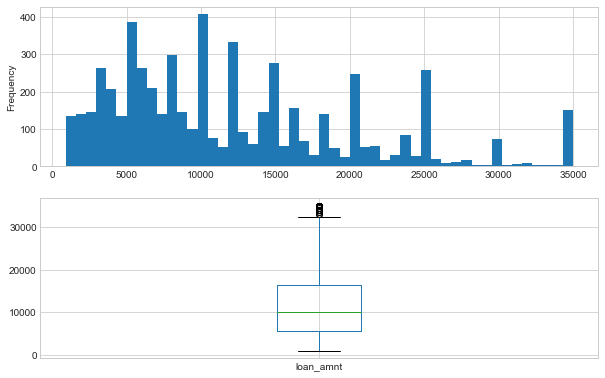

In [475]:
plt.figure(figsize=(10,10))
plt.subplot(311)
loan_df_ChargedOff['loan_amnt'].plot(kind='hist', bins = 50)
plt.subplot(312)
loan_df_ChargedOff['loan_amnt'].plot(kind='box')

In [476]:
loan_df_ChargedOff.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens
1,1077430,1314167,2500,2500,2500.0,60,15.0,60.0,C,C4,...,1.1100,201304,119.66,0,201309,0,1,0,0,0
8,1071795,1306957,5600,5600,5600.0,60,21.0,152.0,F,F2,...,2.0900,201204,152.39,0,201208,0,1,0,0,0
9,1071570,1306721,5375,5375,5350.0,60,13.0,121.0,B,B5,...,2.5200,201211,121.45,0,201303,0,1,0,0,0
12,1064687,1298717,9000,9000,9000.0,36,13.0,305.0,C,C1,...,4.1600,201207,305.38,0,201211,0,1,0,0,0
14,1069057,1303503,10000,10000,10000.0,36,11.0,326.0,B,B2,...,6.3145,201310,325.74,0,201403,0,1,0,0,0


In [477]:
loan_df_ChargedOff.pivot_table(values='loan_amnt', index=['emp_length','loan_status'], aggfunc='count').sort_values(by='loan_amnt', ascending=False).reset_index()

,emp_length,loan_status,loan_amnt
0,10,1,1331
1,0,1,639
2,2,1,567
3,3,1,555
4,4,1,462
5,5,1,458
6,1,1,456
7,6,1,307
8,7,1,263
9,nan,1,228


In [478]:
test1 = loan_df_NotChargedOff.pivot_table(values='loan_amnt', index=['emp_length','loan_status'], aggfunc='count').sort_values(by='loan_amnt', ascending=False).reset_index().pivot_table(index=['emp_length'], values='loan_amnt', aggfunc='sum').sort_values(by='loan_amnt',ascending=False).reset_index()


In [479]:
print(home_ownership_val2Col)
loan_df_NotChargedOff.pivot_table(values='loan_amnt', index=['home_ownership'],aggfunc='sum').sort_values(by='loan_amnt',ascending=False)
#Hight Risk in MORTGAGE and RENT Loan

{0: 'RENT', 1: 'OWN', 2: 'MORTGAGE', 3: 'OTHER'}


,loan_amnt
home_ownership,
2,191294500
0,158897075
1,26485375
3,797525


In [480]:
print(verification_status_col2Val)
loan_df_NotChargedOff.pivot_table(values='loan_amnt', index=['verification_status'],aggfunc='count').sort_values(by='loan_amnt',ascending=False)

{'Verified': 0, 'Source Verified': 1, 'Not Verified': 2}


,loan_amnt
verification_status,
2,14776
0,10758
1,8553


In [481]:
loan_df_ChargedOff.pivot_table(values='loan_amnt', index=['verification_status'],aggfunc='count').sort_values(by='loan_amnt',ascending=False)
#Source Not Verified got More Loan than Source Verified

,loan_amnt
verification_status,
2,2142
0,2051
1,1434


In [483]:
print(home_ownership_col2Val)
print(loan_status_col2Val)
do_analysis_categorical(loan_df,"home_ownership")

{'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3}
{'Fully Paid': 0, 'Charged Off': 1, 'Current': 2}
0    18899
2    17659
1     3058
3       98
Name: home_ownership, dtype: int64
loan_status                                                     0  \
home_ownership                                                      
0               1111111111111111111111111111111111111111111111...   
1               1111111111111111111111111111111111111111111111...   
2               1111111111111111111111111111111111111111111111...   
3               1111111111111111111111111111111111111111111111...   
All             1111111111111111111111111111111111111111111111...   

loan_status                                                     1  \
home_ownership                                                      
0               1111111111111111111111111111111111111111111111...   
1               1111111111111111111111111111111111111111111111...   
2               1111111111111111111111111111111111111111111111

TypeError: Empty 'DataFrame': no numeric data to plot